## Predicting the amount of mexican restaurants based on Hispanic population

### Table of contents
 - Introduction / Business Problem
 - Data
 - Methodology
 - Analysis
 - Results and Discussion
 - Conclusion

### Introduction/Business Problem

Restaurants have a hard time choosing where to build new locations. It depends on a plethora of conditions, such as traffic patterns, proximity to other similar restaurants, and distance from neighborhoods. However, in this project, I look how the amount of Hispanic population in a city affects the diversity of restaurants. I am specifically researching whether or to what extent the Hispanic ethnicity of the population of a city dictates the amount of ‘mexican’ restaurants. This data and research would be of great interest to restaurants of any type as a factor in determining new locations. This project could also be extended to include different ethnicities and more types of restaurants.

### Data

I choose the Phoenix metropolitan area to analyze. It has a variety of ethnicities among its cities, and therefore is bound to have some variation to be scrutinized. I use population data and the ratio or percentage of Hispanics for each city in the Phoenix metropolitan area, gathered from the 2010 census. I am discarding all population in unincorporated areas; only people in the cities of Phoenix are included. There were several cities (about three to five out of thirty) that I did not have ethnicity data for, so I excluded those cities as well.

In my project, I compile the population and demographic data into one dataframe. Then I add the latitude and longitude for each location in my dataframe. Next, I query Foursquare to find the amount of Mexican restaurants in each vicinity, both as a number amount and as a percentage of the total number of restaurants in the area. Lastly, I train and test several models to find the most accurate in predicting the proportion of Mexican restaurants in a given city based on the proportion of Hispanic population. This gives me the ability to give a decision, with reasonable certainty, as to whether another Mexican restaurant might be successful in a certain area. Of course, other data would be needed to determine the exact location and whether there are already too many restaurants for the population. However, this project would be a useful metric in aiding a restaurant chain in deciding on new locations. <br> <br>    

I import the necessary libraries for the project

In [1]:
import requests
import pandas as pd
import numpy as np
import random

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.21.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

<br> 
#### Upload Population data from Github <br> 

In [2]:
 !curl https://raw.githubusercontent.com/prairieschooner/Coursera_Capstone/master/pop_2010_all.csv -o pop_2010_all.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1521  100  1521    0     0   8497      0 --:--:-- --:--:-- --:--:--  8497


In [3]:
pop_all = pd.read_csv('pop_2010_all.csv')
pop_all.head()

,Place,Population
0,Eagar,4885
1,St. Johns,3480
2,Springerville,1961
3,Benson,5105
4,Bisbee,5575


<br> 
#### Upload Ethnicity data from Github <br>

In [4]:
 !curl https://raw.githubusercontent.com/prairieschooner/Coursera_Capstone/master/pop_2010_hispanic.csv -o pop_his.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2381  100  2381    0     0  14430      0 --:--:-- --:--:-- --:--:-- 14430


In [5]:
per_his = pd.read_csv('pop_his.csv')
per_his.head()

,Incorporated Place,Hispanic or Latino,Not Hispanic or Latino,Unnamed: 3
0,Chandler city,21.9,78.1,NaN
1,Tusayan town,40.7,59.3,NaN
2,Gilbert town,14.9,85.1,NaN
3,Tempe city,21.1,78.9,NaN
4,Eloy city,58.0,42.0,NaN


<br> 
#### Upload city data from Github <br> 

In [6]:
 !curl https://raw.githubusercontent.com/prairieschooner/Coursera_Capstone/master/phoenix_cities_towns.csv -o cities.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   523  100   523    0     0   2971      0 --:--:-- --:--:-- --:--:--  2971


In [7]:
cities = pd.read_csv('cities.csv')
del cities['Population']
cities['indices'] = cities.index
cities.head()

,Place,indices
0,Phoenix,0
1,Mesa,1
2,Chandler,2
3,Scottsdale,3
4,Glendale,4


Here I clean the data and combine the three dataframes into one

In [8]:
#Normalizing the dataframe by standardizing the city names
per_his['Place'] = per_his['Incorporated Place'].str.replace(' city', '')
per_his['Place'] = per_his['Place'].str.replace(' town', '')

In [9]:
#Removing unnecessary columns
del per_his['Incorporated Place']
del per_his['Unnamed: 3']
per_his.head()

,Hispanic or Latino,Not Hispanic or Latino,Place
0,21.9,78.1,Chandler
1,40.7,59.3,Tusayan
2,14.9,85.1,Gilbert
3,21.1,78.9,Tempe
4,58.0,42.0,Eloy


In [10]:
pop_his = pd.merge(per_his, pop_all, on='Place')
pop_his = pop_his.sort_values('Place')
pop_his.head()

,Hispanic or Latino,Not Hispanic or Latino,Place,Population
10,50.3,49.7,Avondale,76238
48,22.1,77.9,Benson,5105
59,36.2,63.8,Bisbee,5575
24,38.3,61.7,Buckeye,50876
28,23.7,76.3,Bullhead City,39540


In [11]:
df_places = pd.merge(pop_his, cities, on='Place')
df_places = df_places.sort_values('Place')
del df_places['indices']
df_places.shape
df_places.head()

,Hispanic or Latino,Not Hispanic or Latino,Place,Population
0,50.3,49.7,Avondale,76238
1,38.3,61.7,Buckeye,50876
2,2.9,97.1,Carefree,3363
3,39.0,61.0,Casa Grande,48571
4,8.1,91.9,Cave Creek,5015


<br> 
#### Getting the number of mexican restaurants in each city  <br> 

In this section I need to retrieve a count of all the mexican resaurants in each city from Foursquare.  To do this, I need to define the category of venue to query.  In this case, I am interested in the overall count of restaurants and the count of mexican restaurants for each city.  Therefore, I will use a dictionary with the keys being the cities and the values the count of all restaurants and the count of mexican restaurants.

In [12]:
CLIENT_ID = 'PYW1SVZBKUNQZ1HUUCBORX3L53ALS3Q0H50ESBCFKYG5CGLT' # your Foursquare ID
CLIENT_SECRET = '3SELEI2OV4KFPQ4PXZPBWZ3FME15Q3RUI4KZL4FXCAPBOS12' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PYW1SVZBKUNQZ1HUUCBORX3L53ALS3Q0H50ESBCFKYG5CGLT
CLIENT_SECRET:3SELEI2OV4KFPQ4PXZPBWZ3FME15Q3RUI4KZL4FXCAPBOS12


Adding more columns

In [13]:
df_places['Count of Mexican Restaurants'] = ''
df_places['Total Restaurants'] = ''
df_places['% Mexican of Total'] = ''
df_places.head()

,Hispanic or Latino,Not Hispanic or Latino,Place,Population,Count of Mexican Restaurants,Total Restaurants,% Mexican of Total
0,50.3,49.7,Avondale,76238,,,
1,38.3,61.7,Buckeye,50876,,,
2,2.9,97.1,Carefree,3363,,,
3,39.0,61.0,Casa Grande,48571,,,
4,8.1,91.9,Cave Creek,5015,,,


In [14]:
mex_id = '4bf58dd8d48988d1c1941735'
food_id = '4d4b7105d754a06374d81259'

Getting the count of restaurants from Foursquare

In [15]:
def get_restaurants(df_places):
    total_mr = []
    total_ar = []
    per_mr = []
    
    for x in df_places.index:
        
        location = df_places.at[df_places.index[x], 'Place']
        
        url1 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&intent={}&categoryId={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, location,'match', mex_id)
        results1 = requests.get(url1).json()
        df1 = pd.DataFrame.from_dict(results1)
        result_m = df1.at['totalResults', 'response']
        total_mr.append(result_m)
        
        url2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&intent={}&categoryId={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, location,'match', food_id)
        results2 = requests.get(url2).json()
        df2 = pd.DataFrame.from_dict(results2)
        result_a = df2.at['totalResults', 'response']
        total_ar.append(result_a)
        
        per_mr.append(result_m/result_a * 100)
        
    return total_ar, total_mr, per_mr

In [16]:
ar, mr, per_mr = get_restaurants(df_places)

Update the places dataframe

In [31]:
df_places['Count of Mexican Restaurants'] = mr
df_places['Total Restaurants'] = ar
df_places['% Mexican of Total'] = per_mr
df_places.head()

,Hispanic or Latino,Not Hispanic or Latino,Place,Population,Count of Mexican Restaurants,Total Restaurants,% Mexican of Total
0,50.3,49.7,Avondale,76238,34,97,35.051546
1,38.3,61.7,Buckeye,50876,17,57,29.824561
2,2.9,97.1,Carefree,3363,12,16,75.000000
3,39.0,61.0,Casa Grande,48571,62,70,88.571429
4,8.1,91.9,Cave Creek,5015,8,44,18.181818


Removing extraordinary values (such as when count of mexican restaurants is higher that count from food category)

In [32]:
df_final = df_places
df_final = df_final[df_final['% Mexican of Total'] < 100.0]
df_final.head()

,Hispanic or Latino,Not Hispanic or Latino,Place,Population,Count of Mexican Restaurants,Total Restaurants,% Mexican of Total
0,50.3,49.7,Avondale,76238,34,97,35.051546
1,38.3,61.7,Buckeye,50876,17,57,29.824561
2,2.9,97.1,Carefree,3363,12,16,75.000000
3,39.0,61.0,Casa Grande,48571,62,70,88.571429
4,8.1,91.9,Cave Creek,5015,8,44,18.181818


My dataframe is now finished and ready for analysis

### Methodology

I have cleaned, sorted, and normalized my data from multiple sources. I have a list of cities in the Phoenix metropolitan area.  For each city, I have the percentage of Mexican restaurants and the Hispanic population. 

Next I will use graphs and maps to visualize the data and determine if there is any direct correlation.  I will also search for a correlation to the size of the city (as determined by total popluation).  More correlations to search for could be those regarding the total amount of restaurants or the number of people per restaurant.

Now I need to analyze the data using the methods described above and determine the relationship between the Hispanic population of a city and the amount of Mexican restaurants.

### Analysis

In [34]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [40]:
df_final.head()

,Hispanic or Latino,Not Hispanic or Latino,Place,Population,Count of Mexican Restaurants,Total Restaurants,% Mexican of Total
0,50.3,49.7,Avondale,76238,34,97,35.051546
1,38.3,61.7,Buckeye,50876,17,57,29.824561
2,2.9,97.1,Carefree,3363,12,16,75.000000
3,39.0,61.0,Casa Grande,48571,62,70,88.571429
4,8.1,91.9,Cave Creek,5015,8,44,18.181818


In [43]:
df_final.columns

Index(['    Hispanic or Latino', '    Not Hispanic or Latino', 'Place',
       'Population', 'Count of Mexican Restaurants', 'Total Restaurants',
       '% Mexican of Total'],
      dtype='object')

In [81]:
df_chart = df_final[['    Hispanic or Latino', '% Mexican of Total']]
df_chart.columns

Index(['    Hispanic or Latino', '% Mexican of Total'], dtype='object')

In [82]:
df_chart = df_chart.sort_values(by = ['    Hispanic or Latino'])
df_chart.head()

,Hispanic or Latino,% Mexican of Total
2,2.9,75.000000
10,4.1,73.913043
4,8.1,18.181818
22,8.8,51.376147
27,13.4,33.333333


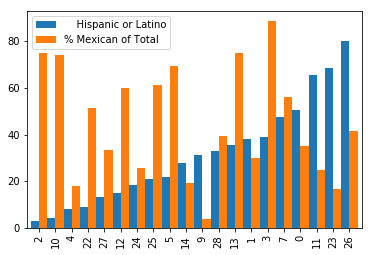

In [83]:
df_chart.plot(kind = 'bar', width=1)

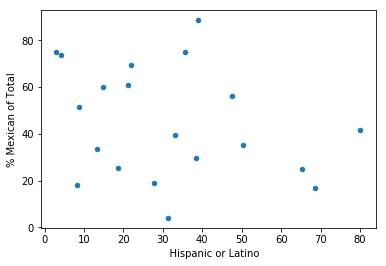

In [84]:
df_chart.plot(kind = 'scatter', x='    Hispanic or Latino', y='% Mexican of Total')

According to the charts above, it seems that the there is actually an inverse relationship between the hispanic population and the amount of Mexican restaurants.

In [85]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [87]:
X = pd.DataFrame(df_chart['    Hispanic or Latino'])
y = pd.DataFrame(df_chart['% Mexican of Total'])

In [89]:
model = LinearRegression()
model.fit(X, y)
model.score(X,y)

0.0778223460247357

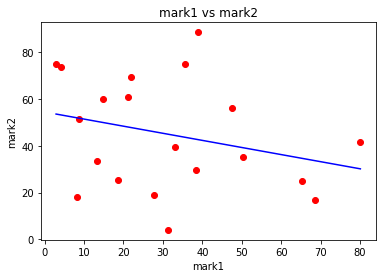

In [91]:
#prediction = model.predict(X)
plt.scatter(X, y, color = 'red')
plt.plot(X, model.predict(X), color = 'blue')
plt.title('Hispanic Population vs Mexican Restaurants')
plt.xlabel('Hispanic Population')
plt.ylabel('Mexican Restaurants')
plt.show()

### Results

As the charts above indicate, there is a slight inverse relationship between the Hispanic population and the amount of Mexican restaurants in the Phoenix metropolitan area.  I used a linear regression model to train and test the data.  The results are not strong, but perhaps seperating the larger cities into sections would help demonstrate a stronger correlation.  Perhaps a non-linear or cluter model are possible candidates to find a better correlation.

### Conclusion

The purpose of this project was fulfilled by identifying the relationship between the two independent variables.  This information is useful in determining possible locations for mexican restaurants in the Phoenix area.  The results indicated that there is a relationship between the ethnicity of the population and the types of restaruants.  This data needs to be analyzed and researched futher.  It can also be combined with other metrics to help determine the suitablity for certain types of restaurants for cities in the Phoenix area.

### Data retrieved from these sites

https://population.az.gov/census-data <br>
https://wpcarey.asu.edu/sites/default/files/census2010az11-11.pdf <br>
https://en.wikipedia.org/wiki/Phoenix_metropolitan_area